In [13]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [14]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import h5py
import seaborn as sns
from sklearn import datasets, linear_model
from tqdm.notebook import tqdm
import random
import math
import json

## Generate data

In [11]:
! python create_shapes_data.py -d -n 1000

Generative parameter        |        States 
------------------------------------------------------------
brain_vol-radminor         [20 21 22 23 24]
brain_vol-radmajor         [26 27 28 29 30]
brain_thick                [1 2 3 4]
brain_int                  [210, 200, 190, 180, 170]
border_int                 ['slateblue', 'mediumslateblue', 'darkslateblue', 'darkblue']
vent_thick                 [1 2 3 4]
shape-top_curv             [ 3  4  5  6  7  8  9 10 11]
shape-top_int              ['lightpink', 'lightsalmon', 'peach', 'rose', 'lightseagreen', 'lightgreen']
shape-top_vol-rad          [2 3 4 5]
shape-midr_curv            [ 3  4  5  6  7  8  9 10 11]
shape-midr_int             ['lightpink', 'lightsalmon', 'peach', 'rose', 'lightseagreen', 'lightgreen']
shape-midr_vol-rad         [2 3 4 5]
shape-midl_curv            [ 3  4  5  6  7  8  9 10 11]
shape-midl_int             ['lightpink', 'lightsalmon', 'peach', 'rose', 'lightseagreen', 'lightgreen']
shape-midl_vol-rad         [2 3 4 5]

## Visualize the data

In [15]:
df = pd.read_csv(glob("shapes/toybrains_n*.csv")[0]).set_index('subjectID')
# sort dataframe cols by column name
df = df.reindex(sorted(df.columns), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cov_age                 1000 non-null   float64
 1   cov_sex                 1000 non-null   object 
 2   cov_site                1000 non-null   object 
 3   gen_border_int          1000 non-null   object 
 4   gen_brain_int           1000 non-null   float64
 5   gen_brain_thick         1000 non-null   float64
 6   gen_brain_vol-radmajor  1000 non-null   float64
 7   gen_brain_vol-radminor  1000 non-null   float64
 8   gen_shape-botl_curv     1000 non-null   float64
 9   gen_shape-botl_int      1000 non-null   object 
 10  gen_shape-botl_vol-rad  1000 non-null   float64
 11  gen_shape-botr_curv     1000 non-null   float64
 12  gen_shape-botr_int      1000 non-null   object 
 13  gen_shape-botr_vol-rad  1000 non-null   float64
 14  gen_shape-midl_curv     1000 non-null   f

### Distribution of generative params

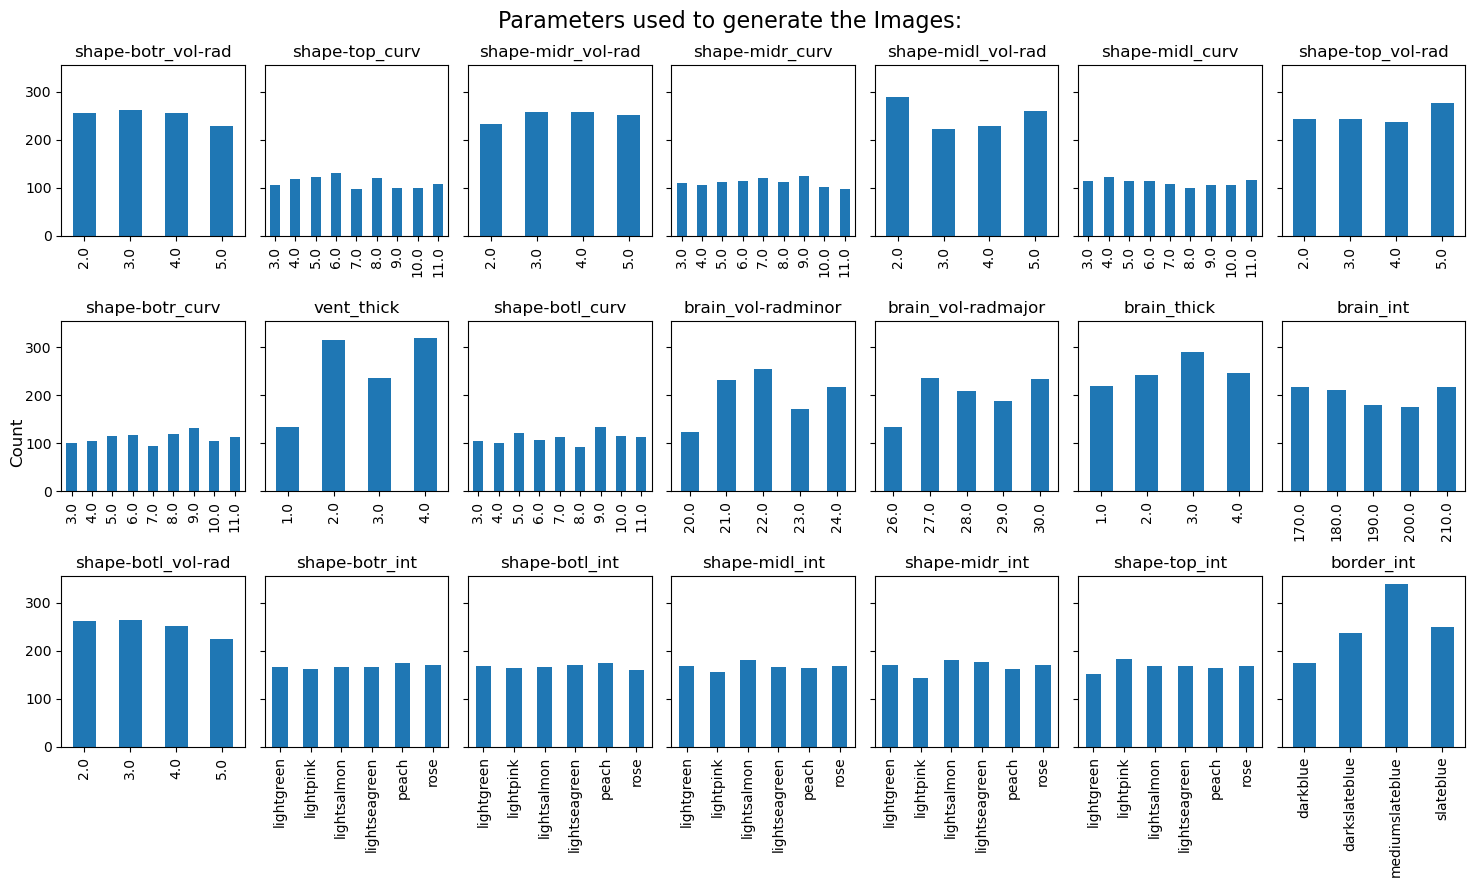

In [16]:
# sort dataframe cols by dtypes
cols = df.filter(like='gen_').dtypes.sort_values().index

f,axes = plt.subplots(len(cols)//7, 7, figsize=(15,3*len(cols)//7), 
                      sharey=True)
axes = axes.ravel()
f.suptitle("Parameters used to generate the Images:", fontsize=16)
f.supylabel("Count")

for i,col in enumerate(cols):
    ax = axes[i]
    df[col].value_counts().sort_index().plot.bar(ax=ax, 
            title=col.replace('gen_',''))
    
plt.tight_layout()
plt.show()

### Distribution of covariates

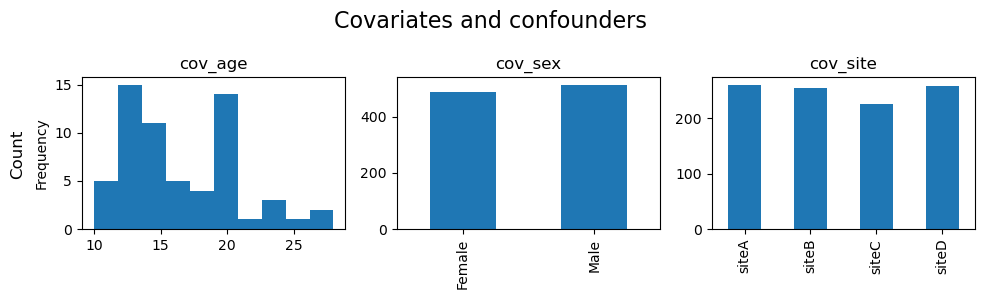

In [19]:
# sort dataframe cols by dtypes
cols = df.filter(like='cov_').dtypes.sort_values().index

f,axes = plt.subplots(1, 3, figsize=(10,3), 
                      sharey=False)
axes = axes.ravel()

f.suptitle("Covariates and confounders", fontsize=16)
f.supylabel("Count")

for i,col in enumerate(cols):
    ax = axes[i]
    kind='bar' if df[col].nunique()<10 else 'hist'
    df[col].value_counts().sort_index().plot(kind=kind, ax=ax, title=col)
    
plt.tight_layout()
plt.show()

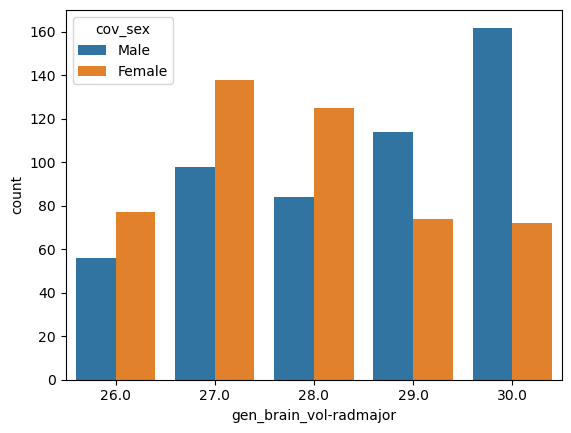

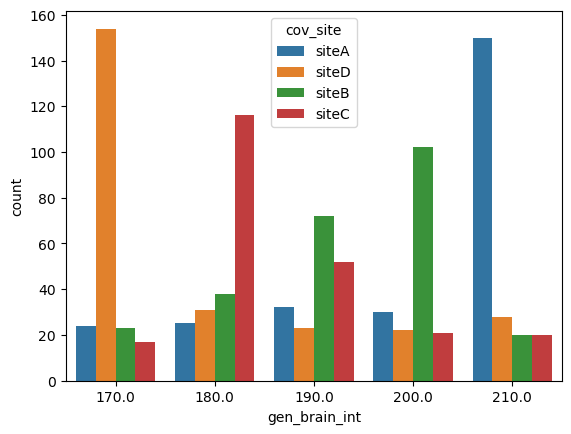

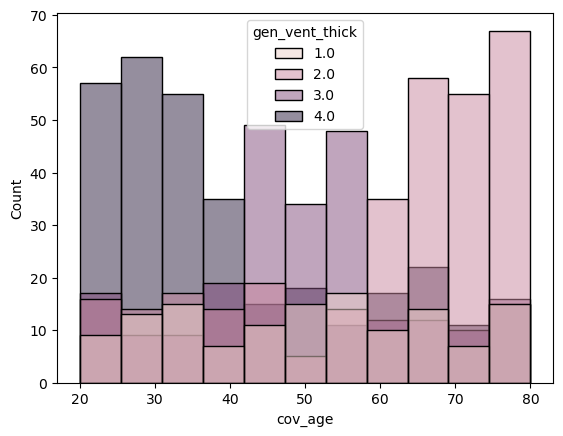

In [40]:
sns.countplot(data=df, x="gen_brain_vol-radmajor", hue="cov_sex")
plt.show()
sns.countplot(data=df, x="gen_brain_int", hue="cov_site")
plt.show()
sns.histplot(data=df, x="cov_age", hue="gen_vent_thick")
plt.show()

### Images

In [16]:
def show_images(img_files, n_rows=1):
    assert isinstance(img_files[0], (str,np.ndarray, np.generic)), "img_files \
should either me a string path to the image files or numpy arrays"   
    n_cols = 10
    f, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols,n_rows), 
                           sharex=True, sharey=True)
    # f.suptitle("Toy brains dataset:")
    axes = axes.ravel()

    for i, img in enumerate(img_files):
        if i<len(axes):
            if isinstance(img, str):
                img = mpimg.imread(img)
            ax = axes[i]
            ax.imshow(img)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

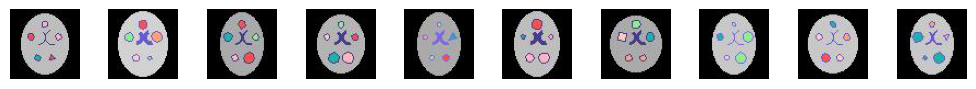

In [17]:
img_files = sorted(glob("shapes/images/*.jpg"))

show_images(img_files=img_files, n_rows=1)

#### All generative variables
1. 'brain_vol' # total volume of the brain ranging between 1633 to 2261 [(S/2-12)*(S/2-6) to (S/2-8)*(S/2-2)]
2. 'brain_thick' # the thickness of the blue border around the brain ranging between 1 to 4
3. 'brain_int', # the intensity or brightness of the brain region ranging between 'greyness0' to 'greyness4'

#### Confounds
2. `age ~ brain_vol & vent_thick` such that `up(age) -> up(vent_thick)` `up(age) -> down(brain_vol)`
3. `sex ~ brain_vol` as a intermediary causal variable such that `male ~ large(brain vol)` `female ~ small(brain vol)`
4. `site ~ outline_color & brain_int` such that 
4. Find citations for (2) and (3)
5. add lesions? 
6. ~add a shape {triangle, square, pentagon, hexagon, ..} at top bottom right and left~

#### Labels
1. purely based on 4 shapes (combinations that are linear and non-linear)
2. partially based on confounder + partially shapes : see the idea from MDN
3. purely based on confounder pathway
4. Create a brain_mask and save it as a label

(40.0, 40.0, 100.0, 100.0) (100.0, 40.0, 160.0, 100.0)


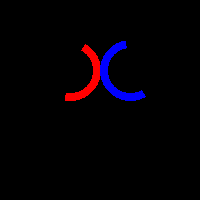

In [237]:
from PIL import Image, ImageDraw
S=200
# Create a new image with a black background
img = Image.new("RGB", (S, S), color="black")

# Draw two arcs at the center of the image, facing opposite to each other and touching at the center
draw = ImageDraw.Draw(img)
x_off, y_off= 0,0
xy_r = (S*.2, S*.2, S*.5, S*.5)
xy_l = (S*.5, S*.2, S*.8, S*.5)
print(xy_r, xy_l)
draw.arc(xy_r, start=300, end=100,   fill="red",  width=8)
draw.arc(xy_l, start=-300, end=-100, fill="blue", width=8)

# Show the image
img